# Project 4 - #WeRateDogs
WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. Your goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

## Setup

In [1]:
import pandas as pd
import numpy as np
import os
import json
from bs4 import BeautifulSoup
from io import BytesIO
from PIL import Image
import requests as r
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tweepy
import statsmodels.api as sms;
from wordcloud import WordCloud, STOPWORDS

In [2]:
pd.options.display.max_colwidth = 280

## `A ` Gathering data

We will be gathering data from 3 sources

`1 ` The WeRateDogs Twitter archive <br>
`2 ` Image predictions based on machine learning predictions <br>
`3 ` Further tweet information via the Twitter API <br>


### `A1 ` The WeRateDogs Twitter archive

I have been given a file "twitter-archive-enhanced.csv" to use, which will be read in to a dataframe via pandas, and then assessed and cleaned in later sections. 

In [3]:
# Read in the file
df_tae = pd.read_csv("twitter-archive-enhanced.csv")

In [4]:
# Save a copy of dataframe for backup
df_tae_backup = df_tae.copy()

In [5]:
df_tae.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


### `A2 ` Image predictions

I have access to a file which predicts each dog's breed via a neural net. I will download this file via the requests library.

In [6]:
path = "."

In [7]:
# Get the url contents

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = r.get(url)
response

<Response [200]>

In [8]:
# Write the url contents to a file
# Use python.split to name the file, everything after the last slash in the url
# Open the file in write binary mode

with open(os.path.join(path, url.split('/',)[-1]), mode = "wb") as file:
    file.write(response.content)

In [9]:
# Read in the file
df_ip = pd.read_csv("image-predictions.tsv", sep="\t")

In [10]:
# Save a copy of dataframe for backup
df_ip_backup = df_ip.copy()

### `A3 ` More tweet information

The file given to us in `A1` doesn't contain the 're-tweet' or 'favourite' counts. This data would be useful to me for latter parts of this project, so I will download this via the Twitter API

In [36]:
#Set up Tweepy 
#https://developer.twitter.com/en/apps/18011785

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [37]:
#Set a counter for timing the api hits

counter = 0
len_tae = df_tae.shape[0]
counter, len_tae

(0, 2356)

In [38]:
# Go through each tweet and save its extended info into a list and write to a txt file
# Thanks to StackOverflow user @taskinoor for highlighting the tweet. _json method
# Source: https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json

tweet_list = []

for tweet in range(len_tae):
    try:
        tweet_id = df_tae['tweet_id'][counter]
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        tweet_list.append(tweet._json)
        with open('tweet_json.txt', "a") as outfile:
            json.dump(tweet._json, outfile)
            outfile.write("\n")
        print(f"Written tweet ",counter, "of", len_tae)
        counter+=1

    except Exception as e:
        print("Error: ", e)
        counter+=1

Written tweet  0 of 2356
Written tweet  1 of 2356
Written tweet  2 of 2356
Written tweet  3 of 2356
Written tweet  4 of 2356
Written tweet  5 of 2356
Written tweet  6 of 2356
Written tweet  7 of 2356
Written tweet  8 of 2356
Written tweet  9 of 2356
Written tweet  10 of 2356
Written tweet  11 of 2356
Written tweet  12 of 2356
Written tweet  13 of 2356
Written tweet  14 of 2356
Written tweet  15 of 2356
Written tweet  16 of 2356
Written tweet  17 of 2356
Written tweet  18 of 2356
Error:  [{'code': 144, 'message': 'No status found with that ID.'}]
Written tweet  20 of 2356
Written tweet  21 of 2356
Written tweet  22 of 2356
Written tweet  23 of 2356
Written tweet  24 of 2356
Written tweet  25 of 2356
Written tweet  26 of 2356
Written tweet  27 of 2356
Written tweet  28 of 2356
Written tweet  29 of 2356
Written tweet  30 of 2356
Written tweet  31 of 2356
Written tweet  32 of 2356
Written tweet  33 of 2356
Written tweet  34 of 2356
Written tweet  35 of 2356
Written tweet  36 of 2356
Writte

Written tweet  290 of 2356
Written tweet  291 of 2356
Written tweet  292 of 2356
Written tweet  293 of 2356
Written tweet  294 of 2356
Written tweet  295 of 2356
Error:  [{'code': 144, 'message': 'No status found with that ID.'}]
Written tweet  297 of 2356
Error:  [{'code': 144, 'message': 'No status found with that ID.'}]
Written tweet  299 of 2356
Written tweet  300 of 2356
Written tweet  301 of 2356
Written tweet  302 of 2356
Written tweet  303 of 2356
Written tweet  304 of 2356
Written tweet  305 of 2356
Written tweet  306 of 2356
Written tweet  307 of 2356
Written tweet  308 of 2356
Written tweet  309 of 2356
Written tweet  310 of 2356
Written tweet  311 of 2356
Written tweet  312 of 2356
Written tweet  313 of 2356
Written tweet  314 of 2356
Written tweet  315 of 2356
Written tweet  316 of 2356
Written tweet  317 of 2356
Written tweet  318 of 2356
Written tweet  319 of 2356
Written tweet  320 of 2356
Written tweet  321 of 2356
Written tweet  322 of 2356
Written tweet  323 of 2356


Written tweet  585 of 2356
Written tweet  586 of 2356
Written tweet  587 of 2356
Written tweet  588 of 2356
Written tweet  589 of 2356
Written tweet  590 of 2356
Written tweet  591 of 2356
Written tweet  592 of 2356
Written tweet  593 of 2356
Written tweet  594 of 2356
Written tweet  595 of 2356
Written tweet  596 of 2356
Written tweet  597 of 2356
Written tweet  598 of 2356
Written tweet  599 of 2356
Written tweet  600 of 2356
Written tweet  601 of 2356
Written tweet  602 of 2356
Written tweet  603 of 2356
Written tweet  604 of 2356
Written tweet  605 of 2356
Written tweet  606 of 2356
Written tweet  607 of 2356
Written tweet  608 of 2356
Written tweet  609 of 2356
Written tweet  610 of 2356
Written tweet  611 of 2356
Written tweet  612 of 2356
Written tweet  613 of 2356
Written tweet  614 of 2356
Written tweet  615 of 2356
Written tweet  616 of 2356
Written tweet  617 of 2356
Written tweet  618 of 2356
Written tweet  619 of 2356
Written tweet  620 of 2356
Written tweet  621 of 2356
W

Written tweet  882 of 2356
Written tweet  883 of 2356
Written tweet  884 of 2356
Written tweet  885 of 2356
Written tweet  886 of 2356
Written tweet  887 of 2356
Written tweet  888 of 2356
Written tweet  889 of 2356
Error:  [{'code': 144, 'message': 'No status found with that ID.'}]
Written tweet  891 of 2356
Written tweet  892 of 2356
Written tweet  893 of 2356
Written tweet  894 of 2356
Written tweet  895 of 2356
Written tweet  896 of 2356
Written tweet  897 of 2356
Written tweet  898 of 2356
Written tweet  899 of 2356


Rate limit reached. Sleeping for: 549


Written tweet  900 of 2356
Written tweet  901 of 2356
Written tweet  902 of 2356
Written tweet  903 of 2356
Written tweet  904 of 2356
Written tweet  905 of 2356
Written tweet  906 of 2356
Written tweet  907 of 2356
Written tweet  908 of 2356
Written tweet  909 of 2356
Written tweet  910 of 2356
Written tweet  911 of 2356
Written tweet  912 of 2356
Written tweet  913 of 2356
Written tweet  914 of 2356
Written tweet  915 of 2356
Written tweet  916 of 2356
Written tweet  917 of 2356
Written tweet  918 of 2356
Written tweet  919 of 2356
Written tweet  920 of 2356
Written tweet  921 of 2356
Written tweet  922 of 2356
Written tweet  923 of 2356
Written tweet  924 of 2356
Written tweet  925 of 2356
Written tweet  926 of 2356
Written tweet  927 of 2356
Written tweet  928 of 2356
Written tweet  929 of 2356
Written tweet  930 of 2356
Written tweet  931 of 2356
Error:  [{'code': 144, 'message': 'No status found with that ID.'}]
Written tweet  933 of 2356
Written tweet  934 of 2356
Written tweet 

Written tweet  1195 of 2356
Written tweet  1196 of 2356
Written tweet  1197 of 2356
Written tweet  1198 of 2356
Written tweet  1199 of 2356
Written tweet  1200 of 2356
Written tweet  1201 of 2356
Written tweet  1202 of 2356
Written tweet  1203 of 2356
Written tweet  1204 of 2356
Written tweet  1205 of 2356
Written tweet  1206 of 2356
Written tweet  1207 of 2356
Written tweet  1208 of 2356
Written tweet  1209 of 2356
Written tweet  1210 of 2356
Written tweet  1211 of 2356
Written tweet  1212 of 2356
Written tweet  1213 of 2356
Written tweet  1214 of 2356
Written tweet  1215 of 2356
Written tweet  1216 of 2356
Written tweet  1217 of 2356
Written tweet  1218 of 2356
Written tweet  1219 of 2356
Written tweet  1220 of 2356
Written tweet  1221 of 2356
Written tweet  1222 of 2356
Written tweet  1223 of 2356
Written tweet  1224 of 2356
Written tweet  1225 of 2356
Written tweet  1226 of 2356
Written tweet  1227 of 2356
Written tweet  1228 of 2356
Written tweet  1229 of 2356
Written tweet  1230 

Written tweet  1488 of 2356
Written tweet  1489 of 2356
Written tweet  1490 of 2356
Written tweet  1491 of 2356
Written tweet  1492 of 2356
Written tweet  1493 of 2356
Written tweet  1494 of 2356
Written tweet  1495 of 2356
Written tweet  1496 of 2356
Written tweet  1497 of 2356
Written tweet  1498 of 2356
Written tweet  1499 of 2356
Written tweet  1500 of 2356
Written tweet  1501 of 2356
Written tweet  1502 of 2356
Written tweet  1503 of 2356
Written tweet  1504 of 2356
Written tweet  1505 of 2356
Written tweet  1506 of 2356
Written tweet  1507 of 2356
Written tweet  1508 of 2356
Written tweet  1509 of 2356
Written tweet  1510 of 2356
Written tweet  1511 of 2356
Written tweet  1512 of 2356
Written tweet  1513 of 2356
Written tweet  1514 of 2356
Written tweet  1515 of 2356
Written tweet  1516 of 2356
Written tweet  1517 of 2356
Written tweet  1518 of 2356
Written tweet  1519 of 2356
Written tweet  1520 of 2356
Written tweet  1521 of 2356
Written tweet  1522 of 2356
Written tweet  1523 

Written tweet  1780 of 2356
Written tweet  1781 of 2356
Written tweet  1782 of 2356
Written tweet  1783 of 2356
Written tweet  1784 of 2356
Written tweet  1785 of 2356
Written tweet  1786 of 2356
Written tweet  1787 of 2356
Written tweet  1788 of 2356
Written tweet  1789 of 2356
Written tweet  1790 of 2356
Written tweet  1791 of 2356
Written tweet  1792 of 2356
Written tweet  1793 of 2356
Written tweet  1794 of 2356
Written tweet  1795 of 2356
Written tweet  1796 of 2356
Written tweet  1797 of 2356
Written tweet  1798 of 2356
Written tweet  1799 of 2356


Rate limit reached. Sleeping for: 542


Written tweet  1800 of 2356
Written tweet  1801 of 2356
Written tweet  1802 of 2356
Written tweet  1803 of 2356
Written tweet  1804 of 2356
Written tweet  1805 of 2356
Written tweet  1806 of 2356
Written tweet  1807 of 2356
Written tweet  1808 of 2356
Written tweet  1809 of 2356
Written tweet  1810 of 2356
Written tweet  1811 of 2356
Written tweet  1812 of 2356
Written tweet  1813 of 2356
Written tweet  1814 of 2356
Written tweet  1815 of 2356
Written tweet  1816 of 2356
Written tweet  1817 of 2356
Written tweet  1818 of 2356
Written tweet  1819 of 2356
Written tweet  1820 of 2356
Written tweet  1821 of 2356
Written tweet  1822 of 2356
Written tweet  1823 of 2356
Written tweet  1824 of 2356
Written tweet  1825 of 2356
Written tweet  1826 of 2356
Written tweet  1827 of 2356
Written tweet  1828 of 2356
Written tweet  1829 of 2356
Written tweet  1830 of 2356
Written tweet  1831 of 2356
Written tweet  1832 of 2356
Written tweet  1833 of 2356
Written tweet  1834 of 2356
Written tweet  1835 

Written tweet  2093 of 2356
Written tweet  2094 of 2356
Written tweet  2095 of 2356
Written tweet  2096 of 2356
Written tweet  2097 of 2356
Written tweet  2098 of 2356
Written tweet  2099 of 2356
Written tweet  2100 of 2356
Written tweet  2101 of 2356
Written tweet  2102 of 2356
Written tweet  2103 of 2356
Written tweet  2104 of 2356
Written tweet  2105 of 2356
Written tweet  2106 of 2356
Written tweet  2107 of 2356
Written tweet  2108 of 2356
Written tweet  2109 of 2356
Written tweet  2110 of 2356
Written tweet  2111 of 2356
Written tweet  2112 of 2356
Written tweet  2113 of 2356
Written tweet  2114 of 2356
Written tweet  2115 of 2356
Written tweet  2116 of 2356
Written tweet  2117 of 2356
Written tweet  2118 of 2356
Written tweet  2119 of 2356
Written tweet  2120 of 2356
Written tweet  2121 of 2356
Written tweet  2122 of 2356
Written tweet  2123 of 2356
Written tweet  2124 of 2356
Written tweet  2125 of 2356
Written tweet  2126 of 2356
Written tweet  2127 of 2356
Written tweet  2128 

In [41]:
# Convert the list to a Pandas dataframe
df_tl = pd.DataFrame(tweet_list)
df_tl = pd.DataFrame(tweet_list)

In [43]:
# Save a copy of dataframe for backup
df_tl_backup = df_tl.copy()

In [42]:
df_tl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2331 non-null   object 
 1   id                             2331 non-null   int64  
 2   id_str                         2331 non-null   object 
 3   full_text                      2331 non-null   object 
 4   truncated                      2331 non-null   bool   
 5   display_text_range             2331 non-null   object 
 6   entities                       2331 non-null   object 
 7   extended_entities              2059 non-null   object 
 8   source                         2331 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

## `B ` Assessing data

I now have the following 3 data sources available:

1. df_tae which contains "twitter-archive-enhanced.csv"
2. df_ip which contains "image-predictions.tsv"
3. df_tl which contains extended data regarding each tweet with ID in df_tae

Next I will visually and programatically assess each data source one by one, and record any quality and/or tidiness issues. I am required, at a minimum, to detect and document at least eight (8) quality issues and two (2) tidiness issues. 

I will also consider all three data sources together as I suspect that once i've been through them individually I will have comments regards their tidiness when considered as one potential dataframe. 

**Method**

I have been through each dataframe with the following methods:

1. Visual assessment of the dataframe by printing it out and scanning through entries
2. Programmatic assessment of the dataframe using functions such as .info(), .value_counts(), .describe(), .head(), .tail(), iloc[row], .sort_values()

I have not kept all of the pandas code in the notebook below for ease of use of this document.

### `B1 ` Assessing "twitter-archive-enhanced.csv"

#### Programmatic and visual assessment

In [17]:
df_tae.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In the head() summary above I notice that the last 4 columns are populated with "None", rather than NaN. I'll run .info()

In [18]:
df_tae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Running .info() confirms that the last 4 columns look like they are well populated with no NaNs, but actually the word "None" has been used where it is not known. Let's count how many actual values are in these columns.

In [19]:
df_tae['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [20]:
df_tae['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [21]:
df_tae['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [22]:
df_tae['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In the project brief it was mentioned that not all rating denominators are equal to 10. Let's have a look at the value counts for this column.

In [23]:
df_tae['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

There are lots of values not equal to 10. Let's see how many. 

In [24]:
df_tae.query('rating_denominator != 10')['rating_denominator'].count()

23

I'll re-run .info() to have another look at the data

In [25]:
df_tae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

It looks like some columns starting "in_reply.." and "retweeted.." have lots of missing data.

Let's have another look over a sample of data to see if there are any other issues we can spot

In [26]:
df_tae.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
451,818627210458333184,NaN,NaN,2017-01-10 01:15:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Wafer. He represents every fiber of my being. 13/10 very good dog https://t.co/I7bkhxBxUG,NaN,NaN,NaN,https://twitter.com/dog_rates/status/818627210458333184/photo/1,13,10,Wafer,None,None,None,None
94,874012996292530176,NaN,NaN,2017-06-11 21:18:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Sebastian. He can't see all the colors of the rainbow, but he can see that this flag makes his human happy. 13/10 #PrideMonth puppo https://t.co/XBE0evJZ6V",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/874012996292530176/photo/1,https://twitter.com/dog_rates/status/874012996292530176/photo/1",13,10,Sebastian,None,None,None,puppo
1455,695409464418041856,NaN,NaN,2016-02-05 00:51:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bob. He just got back from his job interview and realized his ear was inside-out the whole time. 10/10 https://t.co/lORINwFXIV,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695409464418041856/photo/1,10,10,Bob,None,None,None,None
930,754449512966619136,NaN,NaN,2016-07-16 22:55:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Dex. He can see into your past and future. Mesmerizing af 11/10 https://t.co/0dYI0Cpdge,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754449512966619136/photo/1,11,10,Dex,None,None,None,None
1055,742385895052087300,NaN,NaN,2016-06-13 15:59:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phil. That's his comfort stick. He holds onto it whenever he's sad. 11/10 don't be sad Phil https://t.co/ULdPY6CLpq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/742385895052087300/photo/1,11,10,Phil,None,None,None,None
945,752660715232722944,NaN,NaN,2016-07-12 00:27:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Hooman used Pokeball\n*wiggle*\n*wiggle*\nDoggo broke free \n10/10 https://t.co/bWSgqnwSHr,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/752660715232722944/photo/1,https://twitter.com/dog_rates/status/752660715232722944/photo/1",10,10,None,doggo,None,None,None
498,813130366689148928,8.131273e+17,4.196984e+09,2016-12-25 21:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been informed by multiple sources that this is actually a dog elf who's tired from helping Santa all night. Pupgraded to 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
1964,673350198937153538,NaN,NaN,2015-12-06 03:56:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bella. She's a Genghis Flopped Canuck. Stuck in trash can. 9/10 not to happy about it https://t.co/RMv9EAv57u,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673350198937153538/photo/1,9,10,Bella,None,None,None,None
177,857393404942143489,NaN,NaN,2017-04-27 00:38:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Instead of the usual nightly dog rate, I'm sharing this story with you. Meeko is 13/10 and would like your help \n\nhttps://t.co/Mj4j6QoIJk https://t.co/JdNE5oqYEV",NaN,NaN,NaN,"https://www.gofundme.com/meeko-needs-heart-surgery,https://twitter.com/dog_rates/status/857393404942143489/photo/1,https://twitter.com/dog_rates/status/857393404942143489/photo/1,https://twitter.com/dog_rates/status/857393404942143489/photo/1,https://twitter.com/dog_rates/sta...",13,10,None,None,None,None,None
688,787810552592695296,NaN,NaN,2016-10-17 00:20:47 +0000

I notice that the name column has lot's of "None" values. Let's have a look at the value count for this column

In [27]:
df_tae['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
           ... 
Vince         1
Flurpson      1
Heinrich      1
Charl         1
Winifred      1
Name: name, Length: 957, dtype: int64

Again, the value "None" has been used to describe missing data, but this can be missed by the programmatic method of issue spotting.

#### Quality issues

* Completeness issue. The following columns are not well populated: "doggo" (97 counts), "floofer" (10 counts), "pupper" (257 counts) and "puppo" (30 counts). Summed and deducted from the total, this means that 1,962 tweets do not have any information in these columns

* Validity issue. There are 23 entries which have a rating_denominator not equal to 10

* Completeness issue. There are 5 columns which have a lot of null values: "in_reply_to_user_id" and "in_reply_to_status_id" (78 non-nulls each) 

* Validity issue. There are 181 entries which are retweets. As per the Project's requirements, retweets are not wanted in this dataset. 

* Completeness issue. There are 745 entries in the "name" column which are "None" and 55 which are "a". 

#### Tidiness issues

* The dataframe is not well designed to store the type of dog (if known), and currently has 4 columns to collect this informatin - "doggo", "floofer", "pupper" and "puppo"

### `B2 ` Assessing "image-predictions.tsv"

#### Programmatic and visual assessment

In [28]:
df_ip.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [29]:
df_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The first thing I notice visually is the different shapes of the datasets. The archive has information about 2356 tweets while this image prediction file only has 2075. 

I also noticed when running .tail() that some of the neural net's first predictions were not actually dog breeds at all. I'll run some more code to see what is going on here

In [30]:
df_ip['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

I also noticed that the prediction confidence levels weren't very high. Let's look into that in more detail

In [31]:
df_ip['p1_conf'].describe()

count    2075.000000
mean        0.594548
std         0.271174
min         0.044333
25%         0.364412
50%         0.588230
75%         0.843855
max         1.000000
Name: p1_conf, dtype: float64

#### Quality issues

* Completeness issue. This dataframe has 2075 entries while the total population is 2356, therefore 281 tweets have not had their images interpreted by the neural net. 
* Accuracy issue. The neural nets' best guess of dog breed is stored in column "p1" and column "p1_dog" is a boolean confirming whether or not this best guess is a dog breed (True) or not (False). There are 543 false entries for "p1_dog". 
* Accuracy issue. Based on the best guess data in column "p1_conf" the mean is 59.4% and the median is 58.9%. These values are low. 

#### Tidiness issues

* I don't consider there to be any tidiness issues with this dataframe

### `B3 ` Assessing extended data regarding each tweet

Note to assessor: I have not included any programmatic code here as I would need to re-run my tweepy API code again to build my dataframe. Hopefully I have displayed my skills in B1 and B2 to a satisfactory level. Thanks. 

#### Quality issues

* Completeness issue. A number of columns have significant amounts of missing data, for example: "geo", "coordinates", "place", "contributors", as well as all the columns starting "in_reply_to..." and "quoted_status.."
* Duplicated data. Columns "id" and "id_str" contain the same data in different formats
* Readability issue. The data in column "source" is potentially interesting but it's currently in a unreadble form

#### Tidiness issues

* The data in the "timestamp" column is aggregated rather than being split into it's constitutional parts, eg day, month, year, minute, hour, etc

### `B4 `  Summary

Having assessed each of the three dataframes I have come to the conclusion that they would tidier by being represented in one dataframe, as they form one observational object, eg tweets. I present this conclusion as my second "tidiness" issue for the purposes of this project, with the first being timestamp/date information that is aggregated in the dataframes. 

## `C ` Cleaning data

Firstly I will create a single dataframe containing the data series' I want to use for my analysis. Once I have created one single dataframe I will then define the cleaning to be done, before coding and testing and finally storing my clean dataframe for analysis. 

### `C1 ` Tweet Analysis dataframe

I will form a dataframe consisting of the following columns (source dataframe indicated in brackets)

1. tweet_id (df_tae)
2. timestamp (df_tae)
3. source (df_tae)
4. text (df_tae)
5. ratings_numerator (df_tae)
6. rating_denominator (df_tae)
7. name (df_tae)
8. retweet_count (df_tl)
9. favorite_count (df_tl)
10. predicted_breed1 (df_ip)
11. predicted_breed1_conf (df_ip)
12. predicted_breed1_dog (df_ip)
13. predicted_breed2 (df_ip)
14. predicted_breed2_conf (df_ip)
15. predicted_breed2_dog (df_ip)
16. predicted_breed3 (df_ip)
17. predicted_breed3_conf (df_ip)
18. predicted_breed3_dog (df_ip)

I will build a new dataframe (based off df_tae) called df_ta (tweet analysis). I will pull in the retweeted tweets, drop them and then drop the column which contained their markers. I will then merge in the required columns from df_ip and df_tl. I will do this merge on an inner join basis as I want a fully populated dataframe. 

In [182]:
df_ta, df_temp1, df_temp2 = [], [], []

In [183]:
# Create a new master dataframe for the final tweet analysis
# Add required columns from df_tae

df_ta = df_tae[['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator', 
                'rating_denominator', 'name', 'retweeted_status_id']].copy()

In [184]:
# Remove the retweets and then drop the column which contained that data

df_ta = df_ta[df_ta['retweeted_status_id'].isnull()]
df_ta = df_ta.drop(columns="retweeted_status_id")

In [185]:
# Create a temporary dataframe to pull out the 2 required columns from df_tl
# I am also pulling through the 'entities' column to extract further information later on

df_temp1 = df_tl[['id', 'retweet_count', 'favorite_count', 'entities']].copy()

In [186]:
# Rename the id column to give it the same name as df_ta, to make future merge simple
df_temp1.rename(columns={'id':'tweet_id'}, inplace=True);

In [187]:
# Create a second temporary dataframe to pull out required columns from df_ip

df_temp2 = df_ip.copy()
df_temp2 = df_temp2.drop(columns=['jpg_url', 'img_num'])

In [188]:
# Merge the temporary dataframes into the new dataframe to be used for analysis

df_ta = pd.merge(df_ta, df_temp1)
df_ta = pd.merge(df_ta, df_temp2)

### `C2 ` Cleaning data - Define/Clean/Test

Here is my new base dataframe to be cleaned:

In [167]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1987 non-null   int64  
 1   timestamp           1987 non-null   object 
 2   source              1987 non-null   object 
 3   text                1987 non-null   object 
 4   rating_numerator    1987 non-null   int64  
 5   rating_denominator  1987 non-null   int64  
 6   name                1987 non-null   object 
 7   retweet_count       1987 non-null   int64  
 8   favorite_count      1987 non-null   int64  
 9   entities            1987 non-null   object 
 10  p1                  1987 non-null   object 
 11  p1_conf             1987 non-null   float64
 12  p1_dog              1987 non-null   bool   
 13  p2                  1987 non-null   object 
 14  p2_conf             1987 non-null   float64
 15  p2_dog              1987 non-null   bool   
 16  p3    

First I will take a copy of this dataset for backup

In [50]:
df_ta_copy = df_ta.copy()

After tidying my data into one single dataframe some of the quality and tidiness issues noted in the assessment stage have been overcome. Those which are still valid are copied here for reference, however having dropped some rows of data the numbers of entries noted originally might not reflect the new data.

1. Validity issue. There are 23 entries which have a rating_denominator not equal to 10
2. Completeness issue. There are 745 entries in the "name" column which are "None" and 55 which are "a". There are other names which are also not real names and are probably the result of incorrect parsing. I will remove these. 
3. Tidiness issue. The dog type (doggo, floofer, pupper, puppo) columns should be reduced to 1 column with NaN for any where dog type is not known.
4. Accuracy issue. The neural nets' best guess of dog breed is stored in column "p1" and column "p1_dog" is a boolean confirming whether or not this best guess is a dog breed (True) or not (False). There are 543 false entries for "p1_dog". 
5. Accuracy issue. Based on the best guess data in column "p1_conf" the mean is 59.4% and the median is 58.9%. These values are low. 
6. Readability issue. The data in column "source" is potentially interesting but it's currently in a unreadble form.

I will tackle each of these separately with an iterative define/clean/test approach.

**1. Validity issue. There are 23 entries which have a rating_denominator not equal to 10**

In [51]:
df_ta['rating_denominator'].value_counts()

10     1969
50        3
80        2
11        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

We now have 18 entries where the denominator is not equal to 10. Before deciding how to proceed with these 18 entries, let's take a look at them.

In [52]:
df_ta.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,entities,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
319,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70,None,3280,12345,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 820690162338279425, 'id_str': '820690162338279425', 'indices': [76, 99], 'media_url': 'http://pbs.twimg.com/media/C2OtWrzUsAE8i0D.jpg', 'media_url_https': 'https://pbs.twimg.com/media/C2OtWrzUsA...",West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True
381,810984652412424192,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7,Sam,1465,5434,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/98tB8y7y7t', 'expanded_url': 'https://www.gofundme.com/sams-smile', 'display_url': 'gofundme.com/sams-smile', 'indices': [120, 143]}], 'media': [{'id': 810984648008466432, 'id_str': '810984648...",golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True
657,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150,None,2229,4813,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 758467147756691456, 'id_str': '758467147756691456', 'indices': [55, 78], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/758467147756691456/pu/img/YTNzjRFDSPNXukmM.jpg', 'media_url_https':...",Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True
794,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11,None,13262,34861,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 740373148126859264, 'id_str': '740373148126859264', 'indices': [117, 140], 'media_url': 'http://pbs.twimg.com/media/CkZVdJ9W0AA4B1D.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CkZVdJ9W...",golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True
842,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170,this,1257,3817,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 731156013890428928, 'id_str': '731156013890428928', 'indices': [98, 121], 'media_url': 'http://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CiWWhVNUY...",lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False
885,722974582966214656,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20,None,1545,4062,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 722974578855804928, 'id_str': '722974578855804928', 'indices': [41, 64], 'media_url': 'http://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CgiFjIpWgA...",Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,Tr

After visually assessing this data there seems to be a few different things going on. 

1. Some tweets are referring to multiple dogs, and the unique scoring system has been altered by the user to reflect this. For example, one photo shows 7 puppies and the score given is 84/70

2. Some tweets include a date in the format mm/dd which appears before the score in the tweet's text. When parsed, the date has been used instead of the score. 

3. Other examples where the tweet's text contained two numbers separated by a "/", one in reference to the shopping store 7/11 and another referencing a dog with 3 & 1/2 legs. 

After consideration and for the purposes of this project, I have decided to remove all of these records from the dataset. They could be cleaned individually, and below I will demonstrate how I would clean them, but then I will remove the remainder. 

In [53]:
# Access individual values to edit then show the updated record

df_ta.at[1966, 'rating_numerator'] = 9
df_ta.at[1966, 'rating_denominator'] = 10
df_ta.loc[1966]['rating_numerator'], df_ta.loc[1966]['rating_denominator']

(9, 10)

For future analysis I will now create a new column which will hold the "score" given for the photo, eg a dog rated as 13/10 will score 130%

In [54]:
df_ta['score'] = df_ta['rating_numerator'] / df_ta['rating_denominator']

In [55]:
# Test to check that worked
df_ta['score'].head()

0    1.3
1    1.3
2    1.2
3    1.3
4    1.2
Name: score, dtype: float64

**2. Completeness issue. There are 745 entries in the "name" column which are "None" and 55 which are "a".**


After re-arranging the dataframes I now have 546 "None" values and 55 "a" values in the name column. I am highlighting this as a completeness issue as I had originally imagined that using the dog's names would be useful data when analysing and visualising the data to create interesting output. However I do not have names for approximately 1/3rd of the dogs. 

I will sample some of the entries where name is "None" to see what has happened. Perhaps the dog's name was never included in the tweet text, or the parsing hasn't picked it up.

In [189]:
df_ta.query('name == "None" | name == "a"').sample(20)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,entities,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
995,708130923141795840,2016-03-11 03:22:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please stop sending in non canines like this Guatemalan Twiggle Bunny. We only rate dogs. Only send in dogs... 11/10 https://t.co/XKhobeGuvT,11,10,None,845,3358,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 708130917802450944, 'id_str': '708130917802450944', 'indices': [117, 140], 'media_url': 'http://pbs.twimg.com/media/CdPJUWIWIAAIchl.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CdPJUWIW...",French_bulldog,0.710354,True,Chihuahua,0.262302,True,Cardigan,0.006904,True
1065,702321140488925184,2016-02-24 02:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please enjoy this picture as much as I did. 12/10 https://t.co/7u8mM99Tj5,12,10,None,1034,3257,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 702321133908054017, 'id_str': '702321133908054017', 'indices': [50, 73], 'media_url': 'http://pbs.twimg.com/media/Cb8lWajW0AEDOsY.jpg', 'media_url_https': 'https://pbs.twimg.com/media/Cb8lWajW0A...",West_Highland_white_terrier,0.769159,True,Scotch_terrier,0.064369,True,Old_English_sheepdog,0.043763,True
1942,666781792255496192,2015-11-18 00:55:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Bacardi named Octaviath. Can shoot spaghetti out of mouth. 10/10 https://t.co/uEvsGLOFHa,10,10,a,179,366,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 666781788895911936, 'id_str': '666781788895911936', 'indices': [84, 107], 'media_url': 'http://pbs.twimg.com/media/CUDigRXXIAATI_H.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CUDigRXXI...",Italian_greyhound,0.618316,True,Weimaraner,0.151363,True,vizsla,0.085989,True
1857,668297328638447616,2015-11-22 05:17:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",2 rare dogs. They waddle (v inefficient). Sometimes slide on bellies. Right one wants to be aircraft Marshall. 9/10s https://t.co/P8bivfp5sU,9,10,None,283,603,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 668297325815717888, 'id_str': '668297325815717888', 'indices': [117, 140], 'media_url': 'http://pbs.twimg.com/media/CUZE4IWW4AAZmDf.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CUZE4IWW...",king_penguin,0.606747,False,ice_bear,0.264221,False,Eskimo_dog,0.032784,True
1298,684200372118904832,2016-01-05 02:30:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Gang of fearless hoofed puppers here. Straight savages. Elevated for extra terror. Front one has killed before 6/10s https://t.co/jkCb25OWfh,6,10,None,1027,2143,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 684200328540098561, 'id_str': '684200328540098561', 'indices': [117, 140], 'media_url': 'http://pbs.twimg.com/media/CX7EkuHWkAESLZk.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CX7EkuHW...",llama,0.681347,False,ram,0.120142,False,hog,0.043686,False
1886,667801013445750784,2015-11-20 20:25:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",OMIGOD 12/10 https://t.co/SVMF4Frf1w,12,10,None,93,316,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 667801007443677184, 'id_str': '667801007443677184', 'indices': [13, 36], 'media_url': 'http://pbs.twimg.com/media/CUSBemVUEAAn-6V.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CUSBemVUEA...",flat-coated_retriever,0.508392,True,Chesapeake_Bay_retriever,0.262239,True,curly-coated_retriever,0.048920,True
1342,681679526984871937,2015-12-29 03:33:58 +00

Having visually assessed a sample of records it seems that the name values are correctly "None" and "a" - names haven't been included in the original tweet text. I will now update the records for these tweets to change from "None" and "a" to a NaN.

In [190]:
df_ta.loc[df_ta['name'] == "None", "name"] = np.NaN
df_ta.loc[df_ta['name'] == "a", "name"] = np.NaN

In [194]:
# Check for NaN's
df_ta['name'].value_counts(dropna=False)

NaN        644
Cooper      10
Charlie     10
Oliver      10
Penny        9
          ... 
Emmie        1
Zuzu         1
Ebby         1
Dawn         1
Theo         1
Name: name, Length: 912, dtype: int64

Let's take another look at the names in the name column

In [198]:
df_ta['name'].to_string()

'0              Phineas\n1                Tilly\n2               Archie\n3                Darla\n4             Franklin\n5                  NaN\n6                  Jax\n7                  NaN\n8                 Zoey\n9               Cassie\n10                Koda\n11               Bruno\n12                 NaN\n13                 Ted\n14              Stuart\n15              Oliver\n16                 Jim\n17                Zeke\n18             Ralphus\n19              Gerald\n20             Jeffrey\n21                 NaN\n22              Canela\n23                 NaN\n24                 NaN\n25                Maya\n26              Mingus\n27               Derek\n28              Roscoe\n29             Waffles\n30               Jimbo\n31              Maisey\n32                 NaN\n33                Earl\n34                Lola\n35               Kevin\n36                 NaN\n37                Yogi\n38                Noah\n39               Bella\n40           Grizzwald\n41             

On further visual assessment there are other incorrectly recorded names in the dataset. These are obvious by the lack of a capitalised first letter. So let's remove any entries in the 'Name' column which don't start with a capital letter, and change them to NaN

In [193]:
# Find any names with all lowercase characters, excluding NaNs, and change them to NaN
df_ta.loc[df_ta['name'].str.islower().fillna(False), 'name'] = np.NaN

In [199]:
# Check that worked by counting names with all lowercase letters
df_ta[df_ta['name'].str.islower().fillna(False)]['name'].count()

0

**3. Tidiness issue. The dog type (doggo, floofer, pupper, puppo) columns should be reduced to 1 column with NaN for any where dog type is not known.**

In [59]:
# Show the dataframe
df_tae.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
252,844973813909606400,NaN,NaN,2017-03-23 18:07:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Brady. He's a recovering alcoholic. Demonstrating incredible restraint here. 12/10 don't give pup, don't give in, Brady https://t.co/B1iBuSq3hr",NaN,NaN,NaN,https://twitter.com/dog_rates/status/844973813909606400/photo/1,12,10,Brady,None,None,None,None
1342,704819833553219584,NaN,NaN,2016-03-02 00:05:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Chesterson. He's a Bolivian Scoop Dog. Incredibly portable. Can't bark for shit tho. 7/10 would still pet https://t.co/EatAd8JhyW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704819833553219584/photo/1,7,10,Chesterson,None,None,None,None
360,829861396166877184,NaN,NaN,2017-02-10 01:15:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Mia. She already knows she's a good dog. You don't have to tell her. 12/10 would probably tell her anyway https://t.co/xeudgDXmTU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/829861396166877184/photo/1,12,10,Mia,None,None,None,None
102,872620804844003328,NaN,NaN,2017-06-08 01:06:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Monkey. She's supporting owners everywhere with her fancy #PrideMonth bandana. 13/10 love is love is love... https://t.co/lUcpnZDPz9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872620804844003328/photo/1,13,10,Monkey,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1",13,10,a,None,None,None,None


In [60]:
df_tae['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [61]:
# Add one new column to consolidate all 4 columns in to one
df_tae['dog_type'] = ""

In [62]:
# Go through each row and update dog_type if it is given
for tweet in df_tae:
    df_tae.loc[df_tae['doggo'] == "doggo", 'dog_type'] = "doggo"
    df_tae.loc[df_tae['floofer'] == "floofer", 'dog_type'] = "floofer"
    df_tae.loc[df_tae['pupper'] == "pupper", 'dog_type'] = "pupper"
    df_tae.loc[df_tae['puppo'] == "puppo", 'dog_type'] = "puppo"

In [63]:
# If there is no type, replace any blanks with NaN values 
df_tae['dog_type'].replace("", np.nan, inplace=True)

In [64]:
df_tae['dog_type'].value_counts()

pupper     257
doggo       83
puppo       30
floofer     10
Name: dog_type, dtype: int64

In [65]:
# Drop the 4 columns which are no longer needed
df_tae.drop(columns=["doggo", "floofer", "pupper", "puppo"], inplace=True);

In [66]:
# Check this has worked
df_tae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  dog_type                    380 n

**4. Accuracy issue. The neural nets' best guess of dog breed is stored in column "p1" and column "p1_dog" is a boolean confirming whether or not this best guess is a dog breed (True) or not (False). There are 543 false entries for "p1_dog"**

*AND*

**5. Accuracy issue. Based on the first prediction data in column "p1_conf" the mean is 59.4% and the median is 58.9%. These values are low**

Let's take another look at this data

In [67]:
df_ta.loc[:, "p1":"p3_dog"].head()

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [68]:
# Confirm how many False 
df_ta['p1_dog'].value_counts()[False]

517

In [69]:
# Show how confident the neural net was with it's primary prediction
df_ta['p1_conf'].describe()

count    1987.000000
mean        0.593317
std         0.271959
min         0.044333
25%         0.361530
50%         0.587342
75%         0.844583
max         1.000000
Name: p1_conf, dtype: float64

When considering what analyses I could do with this data I quickly considered that it would be excellent to be able to rank the photos and then use this information from the neural net to discover which breeds of dog were top of the table. However 517 values from p1 are missing, which is about a quarter of my dataset. This will, depending on which tweets rank highest, make my analyses incomplete, and without manually identifying the missing breeds and without re-running them through another neural net I don't see a way through this. 

Furthermore, the confidence of the neural net for it's primary prediction are not as high as I would like, with the mean and median at 59%. To make my analysis trustworthy I would need to manually check the breeds of the highest ranking dogs. 

**Extracting day of week from timestamp data**

First i'll print out a sample, and then consider what constitutional parts of this data might be useful for my analysis

In [70]:
df_ta['timestamp'].sample(10)

764     2016-06-21 00:54:33 +0000
1493    2015-12-12 18:13:51 +0000
1219    2016-01-19 03:32:10 +0000
254     2017-02-15 01:04:21 +0000
1021    2016-03-06 05:11:12 +0000
551     2016-09-18 21:33:11 +0000
718     2016-07-04 17:00:26 +0000
326     2017-01-12 00:55:47 +0000
1753    2015-11-28 02:20:27 +0000
83      2017-06-08 01:06:27 +0000
Name: timestamp, dtype: object

I think it would be interesting to see what day of the week is the most popular for people posting tweets rating their dogs, so I will extract this information out from the timestamp column into a new column called "day"

In [71]:
df_ta['timestamp'] = pd.to_datetime(df_ta['timestamp'])

In [72]:
# Add day of the week column
df_ta['day'] = df_ta['timestamp'].apply(lambda x: x.day_name())

In [73]:
# Check that worked and see which day is most popular
df_ta['day'].value_counts()

Monday       327
Tuesday      295
Wednesday    295
Friday       281
Thursday     281
Sunday       256
Saturday     252
Name: day, dtype: int64

**Cleaning**

When p1_dog is False I will update the value in the p1 column to "Unknown"

The probabilities in p2 and p3 are too low to be relied upon, so I have decided I will drop those columns. 

In [74]:
# Updating values of p1 where breed is unknown
df_ta.loc[df_ta['p1_dog'] == False, 'p1'] = "Unknown"

In [75]:
# Check this worked. I expect to see Unknown with count of 517
df_ta['p1'].value_counts()

Unknown               517
golden_retriever      139
Labrador_retriever     93
Pembroke               88
Chihuahua              79
                     ... 
Japanese_spaniel        1
standard_schnauzer      1
EntleBucher             1
Scotch_terrier          1
clumber                 1
Name: p1, Length: 112, dtype: int64

In [76]:
# Drop 6 columns associated with p2 and p3 as this data is not needed
df_ta.drop(df_ta.loc[:, "p2":"p3_dog"], axis="columns", inplace=True);

In [77]:
# Check that worked
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1987 non-null   int64              
 1   timestamp           1987 non-null   datetime64[ns, UTC]
 2   source              1987 non-null   object             
 3   text                1987 non-null   object             
 4   rating_numerator    1987 non-null   int64              
 5   rating_denominator  1987 non-null   int64              
 6   name                1386 non-null   object             
 7   retweet_count       1987 non-null   int64              
 8   favorite_count      1987 non-null   int64              
 9   entities            1987 non-null   object             
 10  p1                  1987 non-null   object             
 11  p1_conf             1987 non-null   float64            
 12  p1_dog              1987 non-null 

**6. Readability issue. The data in column "source" is potentially interesting but it's currently in a unreadble form**

Let's take another look at the contents of the source column

In [78]:
df_ta['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1949
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

It seems that the overwhelming majority of tweets in our sample were made from an iPhone using the official Twitter app. That is interesting! I will consider this as part of my analysis, however for now i'll clean this column up to make it easier to read. As there are only 3 different options I will manually clean this, rather than parsing through the text to extract the source. 

In [79]:
df_ta.loc[df_ta['source'] 
          == """<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>""", 'source'] = "Twitter for iPhone"

df_ta.loc[df_ta['source'] 
          == """<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>""", 'source'] = "Twitter website"

df_ta.loc[df_ta['source'] 
          == """<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>""", 'source'] = "TweetDeck"

In [80]:
# Check this worked
df_ta['source'].value_counts()

Twitter for iPhone    1949
Twitter website         28
TweetDeck               10
Name: source, dtype: int64

### `C3 ` Cleaning Summary

All issues identified for cleaning have been addressed and I now have my final dataframe ready to be exported and used for data analysis

In [200]:
df_ta.shape

(1987, 19)

In [201]:
df_ta.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,entities,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,7697,36153,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXo...",orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,5694,31170,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4X...",Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,3775,23484,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_url': 'http://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGBdLU1W...",Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,7861,39432,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [80, 103], 'media_url': 'http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DF_q7IAWs...",paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,8471,37651,"{'hashtags': [{'text': 'BarkWeek', 'indices': [129, 138]}], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 891327551943041024, 'id_str': '891327551943041024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg', 'media_url_ht...",basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### `C4 ` Gathering image URL's for later access

Now that i've finalised the dataset i'll use for analysis, I will store the image url's for each of these tweets for later use in my analysis. 

In [202]:
# Set up useful variables

img_dict = {}
counter = 0
tweet_num = df_ta.shape[0]

In [203]:
# Loop through all tweets in dataframe to extract tweet_id and corresponding jpg image, store these in a dictionary
while counter < tweet_num:
    tweet_id = df_ta['tweet_id'][counter]
    url = df_ta['entities'][counter]['media'][0]['media_url']
    img_dict[tweet_id] = url
    counter += 1

In [204]:
len(img_dict) == tweet_num

True

## `D ` Saving output

Pandas dataframe to be saved as "twitter_archive_master.csv"

In [205]:
df_ta.to_csv("twitter_archive_master.csv")

## `E ` Data Analysis

My goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

1. Firstly I would like to produce a Top 10 from our dataset, to show which dogs were loved the most. 
2. Second, I would like to see how well the neural net managed to identify the dogs in the Top 10, so I will visually assess the predictions and manually assert whether the neural net was correct or not.
3. Third, I am interested to see which day of the week is most popular for owners tweeting about their dogs, and how they tweet
4. Fourth, it will be interesting to see how the data on retweet count and favourite count correlate with each other. I will use a scatter plot to visualise this, and put the data through an OLS model to interpret the correlation strength and the independent coefficient. 
5. Finally, I will produce a wordcloud visualisation of all the dogs names (where known), which will be a fitting way to round off my analyses.

### `E1 ` Top 10 Dogs #WeLoveDogs

**Method**

After much consideration and testing, I have decided I will add the retweet count and favourite count together to get the best proxy to a dog's popularity. This decision follows steps where I took the 10 dogs with highest retweet count and 10 with highest favourite count and dropped duplicates, but this left me with 12 dogs. The owners ratings are all so similar, there was no obvious way to cut 2 of the dogs from this 12 to get my top 10. Please see below.

Attempt to get a top 10 from the retweet and favourite counts failed

In [206]:
df1 = df_ta.nlargest(10, 'retweet_count')
df2 = df_ta.nlargest(10, 'favorite_count')

In [207]:
df1.drop(columns='entities', inplace=True)
df2.drop(columns='entities', inplace=True)

In [208]:
# Results in 12 dogs with no obvious way to reduce this to 10
df_diff = pd.concat([df1, df2]).drop_duplicates()
df_diff.shape

(12, 18)

Now I will add together retweet and favourite count and take the top 10, and then display these images

In [209]:
df_ta['liked'] = df_ta['retweet_count'] + df_ta['favorite_count']
df3 = df_ta.nlargest(10, 'liked')

**Here are the Top Ten favourite dogs**

In [210]:
df3

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,entities,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,liked
769,744234799360020481,2016-06-18 18:26:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13,10,NaN,77704,155935,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 744234667679821824, 'id_str': '744234667679821824', 'indices': [92, 115], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg', 'media_url_https'...",Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,233639
396,807106840509214720,2016-12-09 06:17:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13,10,Stephan,56644,120430,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 807106774843039744, 'id_str': '807106774843039744', 'indices': [62, 85], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg', 'media_url_https':...",Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,177074
305,822872901745569793,2017-01-21 18:26:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13,10,NaN,43771,132849,"{'hashtags': [{'text': 'WomensMarch', 'indices': [62, 74]}], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 822872859181809664, 'id_str': '822872859181809664', 'indices': [88, 111], 'media_url': 'http://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg', 'media_url_ht...",Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,176620
804,739238157791694849,2016-06-04 23:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13,10,NaN,57626,115174,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 739238016737267712, 'id_str': '739238016737267712', 'indices': [115, 138], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg', 'media_url_https...",Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,0.080901,True,172800
107,866450705531457537,2017-05-22 00:28:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",13,10,Jamesy,32916,116257,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 866450698984185856, 'id_str': '866450698984185856', 'indices': [107, 130], 'media_url': 'http://pbs.twimg.com/media/DAZAUfBXYAAHtni.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DAZAUfBX...",French_bulldog,0.905334,True,Boston_bull,0.078060,True,pug,0.001771,True,149173
58,879415818425184262,2017-06-26 19:07:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,13,10,Duddles,40562,99073,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 879415784908390401, 'id_str': '879415784908390401', 'indices': [83, 106], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg', 'media_url_https'...",English_springer,0.383404,True,Boston_b

In [92]:
folder_name = 'images'
# Make directory if it doesn't already exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [93]:
# Go through each url in the image dictionary, request the contents and write this to an image file

import requests

counter = 0
ranking = 1
image_file_format = url.split('.')[-1]

while counter < df3.shape[0]:
    id = df3.iloc[counter, 0]
    url = img_dict.get(id)
    r = requests.get(url)
    i = Image.open(BytesIO(r.content))
    i.save(folder_name + "/" + str(ranking) + "-" + str(id) + '.' + image_file_format)
    counter+=1
    ranking+=1

**Displaying the top 10 images** The code in the two cells below has been copied from https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell (where it was not the accepted answer) with thanks to user @Michael

In [94]:
images = []
for img_path in glob.glob('images/*.jpg'):
    images.append(mpimg.imread(img_path))

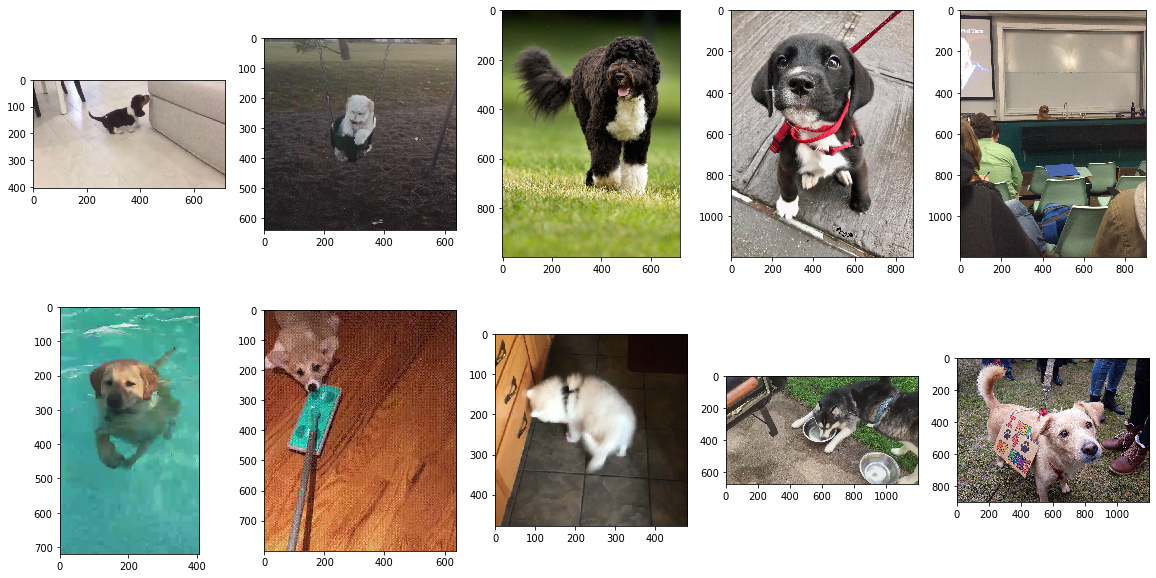

In [95]:
plt.figure(figsize=(20,10))
for i, image in enumerate(images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)

In [211]:
df3['retweet_count'].sum()

441925

In [212]:
df3['favorite_count'].sum()

1068369

**Conclusion** Here we can see the top ten most loved dogs of Twitter (from our data sample anyway!). If time were not an issue I would like to spend some more of it displaying these images in a better format, with ranking position and dog's name & breed (where available), but for now I will leave it here. 

### `E2 ` Neural Net prediction accuracy

Using the top ten dogs as a small sample, I will look to see how accurate the neural net has been in predicting the dogs breed. I will start with the first image in the top left corner above, and work to the right through the 10. After deciding whether or not the neural net was correct I will add a True/False to a new column in the dataframe to keep track of it's performance.

In [98]:
# Set up some counters
img_counter = 0
image_id = df3.iloc[img_counter, 0]

**Image 1**

In [99]:
# Go through each tweet's information, transpose it for ease of display. 
# Here we are looking for the dogs breed, plus any other information contained in the tweet text that might be helpful

df3.loc[df3['tweet_id'] == image_id].T

,769
tweet_id,744234799360020481
timestamp,2016-06-18 18:26:18+00:00
source,Twitter for iPhone
text,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
rating_numerator,13
rating_denominator,10
name,NaN
retweet_count,77704
favorite_count,155935
entities,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 744234667679821824, 'id_str': '744234667679821824', 'indices': [92, 115], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg', 'media_url_https'..."


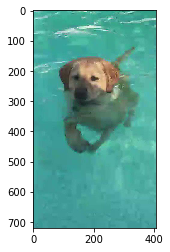

In [100]:
plt.imshow(images[5]);

This dog (our number 1 dog!) is predicted to be a Labrador Retreiever with a confidence of 82.5%. In this case I think the neural net is correct!

In [101]:
# Set the attribute for this dog to True, and move on to the next dog in the top 10

df3.loc[df3['tweet_id'] == image_id, 'p1_correct'] = True
img_counter+=1
image_id = df3.iloc[img_counter, 0]

**Image 2**

In [102]:
df3.loc[df3['tweet_id'] == image_id].T

,396
tweet_id,807106840509214720
timestamp,2016-12-09 06:17:20+00:00
source,Twitter for iPhone
text,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d
rating_numerator,13
rating_denominator,10
name,Stephan
retweet_count,56644
favorite_count,120430
entities,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 807106774843039744, 'id_str': '807106774843039744', 'indices': [62, 85], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg', 'media_url_https':..."


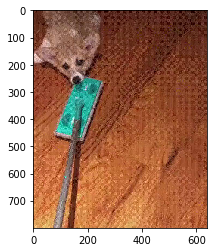

In [103]:
plt.imshow(images[6]);

This dog is predicted to be a Chihuahua with a confidence of 50.5%. In this case I think the neural net is correct!

In [104]:
df3.loc[df3['tweet_id'] == image_id, 'p1_correct'] = True
img_counter+=1
image_id = df3.iloc[img_counter, 0]

**Image 3**

In [105]:
df3.loc[df3['tweet_id'] == image_id].T

,305
tweet_id,822872901745569793
timestamp,2017-01-21 18:26:02+00:00
source,Twitter for iPhone
text,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc
rating_numerator,13
rating_denominator,10
name,NaN
retweet_count,43771
favorite_count,132849
entities,"{'hashtags': [{'text': 'WomensMarch', 'indices': [62, 74]}], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 822872859181809664, 'id_str': '822872859181809664', 'indices': [88, 111], 'media_url': 'http://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg', 'media_url_ht..."


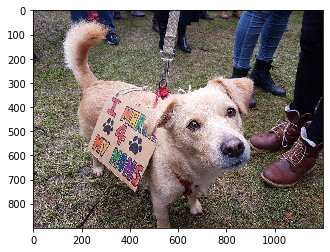

In [106]:
plt.imshow(images[9]);

This dog is predicted to be a Lakeland Terrier with a confidence of 19.6%. In this case I think the neural net is incorrect, based on images of a Lakeland Terrier here: shorturl.at/lEXY2

In [107]:
df3.loc[df3['tweet_id'] == image_id, 'p1_correct'] = False
img_counter+=1
image_id = df3.iloc[img_counter, 0]

**Image 4**

In [108]:
df3.loc[df3['tweet_id'] == image_id].T

,804
tweet_id,739238157791694849
timestamp,2016-06-04 23:31:25+00:00
source,Twitter for iPhone
text,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC
rating_numerator,13
rating_denominator,10
name,NaN
retweet_count,57626
favorite_count,115174
entities,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 739238016737267712, 'id_str': '739238016737267712', 'indices': [115, 138], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg', 'media_url_https..."


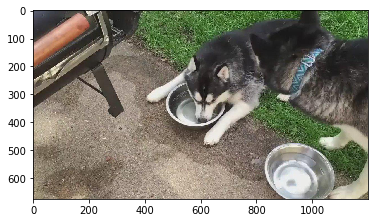

In [109]:
plt.imshow(images[8]);

This dog is predicted to be an Eskimo Dog with a confidence of 50.3%. In this case I think the neural net is correct.

In [110]:
df3.loc[df3['tweet_id'] == image_id, 'p1_correct'] = True
img_counter+=1
image_id = df3.iloc[img_counter, 0]

**Image 5**

In [111]:
df3.loc[df3['tweet_id'] == image_id].T

,107
tweet_id,866450705531457537
timestamp,2017-05-22 00:28:40+00:00
source,Twitter for iPhone
text,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr"
rating_numerator,13
rating_denominator,10
name,Jamesy
retweet_count,32916
favorite_count,116257
entities,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 866450698984185856, 'id_str': '866450698984185856', 'indices': [107, 130], 'media_url': 'http://pbs.twimg.com/media/DAZAUfBXYAAHtni.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DAZAUfBX..."


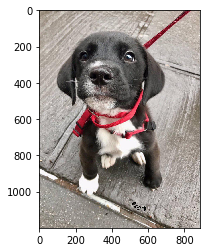

In [112]:
plt.imshow(images[3]);

This dog is predicted to be a French Bulldog with a confidence of 90.5%. In this case I think the neural net is incorrect, and is overly confident of it's prediction. 

In [113]:
df3.loc[df3['tweet_id'] == image_id, 'p1_correct'] = False
img_counter+=1
image_id = df3.iloc[img_counter, 0]

**Image 6**

In [114]:
df3.loc[df3['tweet_id'] == image_id].T

,58
tweet_id,879415818425184262
timestamp,2017-06-26 19:07:24+00:00
source,Twitter for iPhone
text,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY
rating_numerator,13
rating_denominator,10
name,Duddles
retweet_count,40562
favorite_count,99073
entities,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 879415784908390401, 'id_str': '879415784908390401', 'indices': [83, 106], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg', 'media_url_https'..."


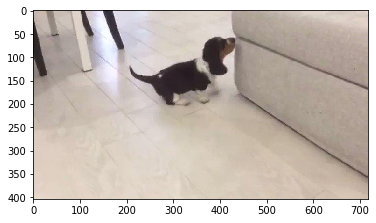

In [115]:
plt.imshow(images[0]);

This dog has been identified as an English Springer by the neural net with a confidence of 38%. I'm no expert, but a google search for English Springer puppies (https://bit.ly/2Bp7fhj) leads me to conclude that this is not an English Springer and the neural net is incorrect. 

In [116]:
df3.loc[df3['tweet_id'] == image_id, 'p1_correct'] = False
img_counter+=1
image_id = df3.iloc[img_counter, 0]

**Image 7**

In [117]:
df3.loc[df3['tweet_id'] == image_id].T

,329
tweet_id,819004803107983360
timestamp,2017-01-11 02:15:36+00:00
source,Twitter for iPhone
text,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1
rating_numerator,14
rating_denominator,10
name,Bo
retweet_count,37362
favorite_count,87973
entities,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 819004789207928832, 'id_str': '819004789207928832', 'indices': [84, 107], 'media_url': 'http://pbs.twimg.com/media/C12whDoVEAALRxa.jpg', 'media_url_https': 'https://pbs.twimg.com/media/C12whDoVE..."


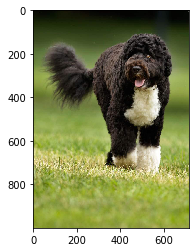

In [118]:
plt.imshow(images[2]);

This dog has been identified as a standard Poodle with a confidence of 35.1%. I think the neural net is correct.

In [119]:
df3.loc[df3['tweet_id'] == image_id, 'p1_correct'] = True
img_counter+=1
image_id = df3.iloc[img_counter, 0]

The last 3 dogs were not predicted by the neural net as dogs. Let's take a quick look at these to see perhaps why

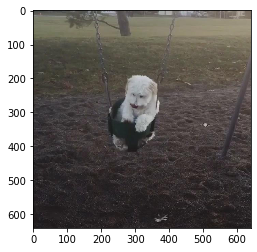

In [120]:
plt.imshow(images[1]);

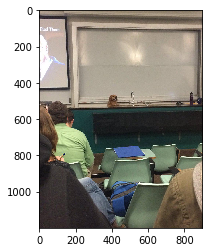

In [121]:
plt.imshow(images[4]);

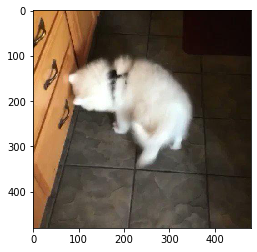

In [122]:
plt.imshow(images[7]);

For each of these 3 images the neural net was unable to correctly predict the subject was a dog, hence it failed in it's job for the purposes of this analysis. However I can understand why it failed, as the images are of poor quality and are not focussed on the dogs faces or bodies, which would be prerequisites for successfully breed/dog identification.

In [216]:
# Run this cell 3 times
df3.loc[df3['tweet_id'] == image_id, 'p1_correct'] = False
image_id = df3.iloc[img_counter, 0]
img_counter+=1

IndexError: single positional indexer is out-of-bounds

Now let's take a look at a summary of the neural net's results

In [217]:
df3[['tweet_id', 'p1', 'p1_conf', 'p1_correct']]

,tweet_id,p1,p1_conf,p1_correct
769,744234799360020481,Labrador_retriever,0.825333,NaN
396,807106840509214720,Chihuahua,0.505370,NaN
305,822872901745569793,Lakeland_terrier,0.196015,NaN
804,739238157791694849,Eskimo_dog,0.503372,NaN
107,866450705531457537,French_bulldog,0.905334,NaN
58,879415818425184262,English_springer,0.383404,NaN
329,819004803107983360,standard_poodle,0.351308,NaN
134,859196978902773760,Angora,0.224218,False
398,806629075125202948,Arabian_camel,0.366248,False
1417,678399652199309312,swing,0.929196,False


**Conclusion**
We can see that the neural net has a 40% success rate, as it correctly predicted the breed of 4 of the dogs in our top 10. However the images for 3 of these dogs were very suboptimal, so perhaps a success rating of 4/7 or 57% is fair. 

### `E3 ` It's Tweet Time

We have date information which has been parsed to show which day of the week the original tweet was made. I am interested to see which days of the week are most popular for tweeting about dogs, so will plot a bar chart showing this.

In [125]:
days = df_ta['day'].value_counts()

In [126]:
days

Monday       327
Tuesday      295
Wednesday    295
Friday       281
Thursday     281
Sunday       256
Saturday     252
Name: day, dtype: int64

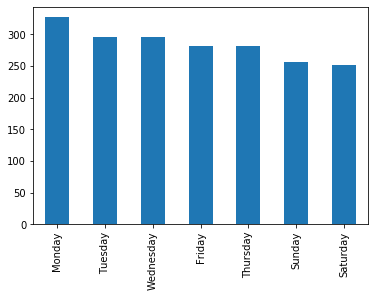

In [127]:
days.plot(kind='bar');

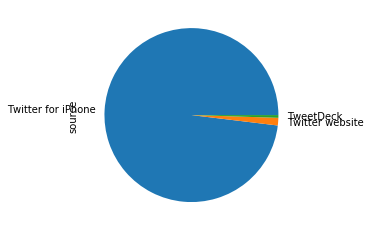

In [128]:
device = df_ta['source'].value_counts()
device.plot(kind='pie');

In [129]:
device

Twitter for iPhone    1949
Twitter website         28
TweetDeck               10
Name: source, dtype: int64

In [130]:
1949/1987

0.980875691997987

**Conclusion** Monday seems to be the most popular day of the week, however there isn't much of a spread between the data so I cannot conclude that any particular day is very popular. Proud dog owners seem to tweet about their dogs every day of the week! 

Over 98% of tweets were made via the Twitter app on an Apple iPhone. From our sample, dog lovers seem to be iPhone lovers too.

### `E4 ` Retweets and Favourites

I'm not a Twitter expert, but I know tweets marked as favorites and retweeted tweet's indicate popularlity. Of these, retweets are probably the holy grail, as Twitter is all about reaching a wide audience and getting attention. So I will analyse my data to investigate the relationship between favourite counts and retweet counts. I predict that the more times a tweet is "favourited" the more retweet's the tweet will get. But I am not sure how strong this relationship will be. 

In [131]:
# Take a copy of the final dataframe 
df_scatter = df_ta.copy()

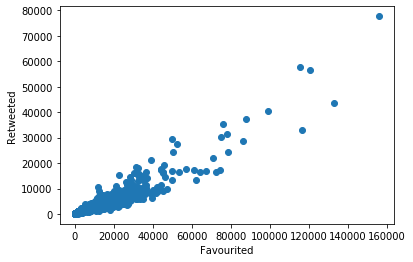

In [132]:
plt.scatter(df_scatter['favorite_count'], df_scatter['retweet_count']);
plt.xlabel("Favourited");
plt.ylabel("Retweeted");

In [133]:
# Add an intercept to enable a simple linear regression analysis
df_scatter['intercept'] = 1

In [134]:
# Set up and fit an Ordinary Least Squares model to analyse the line of best fit

lm = sms.OLS(df_scatter['retweet_count'], df_scatter[['intercept', 'favorite_count']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 1.251e+04
Date:                Sat, 06 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:39:44   Log-Likelihood:                -17508.
No. Observations:                1987   AIC:                         3.502e+04
Df Residuals:                    1985   BIC:                         3.503e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       -316.1676     44.053     -7.177      0.000    -402.563    -229.772
favorite_count     0.3353      0.003    111.863      0.000       0.329       0.341
==============================================================================
Omnibus:                     1789.525   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           242319.340
Skew:                           3.683   Prob(JB):                         0.00
Kurtosis:                      56.597   Cond. No.                     1.78e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Conclusions**

* There is a very strong positive correlation between favourite count and retweet count (r = 91.7). The r-squared figure of 0.84 shows that over 84% of the variation in retweet count is accounted for by the favourited count, which means favourite count is a very strong indicator of retweet count. 
* The favourite count coefficient of 0.30 roughly indicates that for every 3 favourites, the tweet will be retweeted. 

### `E5 ` Word Cloud for Dog's names

As a final step in my analysis I wanted to produce a WordCloud featuring all of the dogs names, showing the most popular names but giving them all an appearance. Credit to GeeksForGeeks for some coding help on the word cloud generation
https://www.geeksforgeeks.org/generating-word-cloud-python

In [218]:
words = '' 
stopwords = set(STOPWORDS)

In [219]:
name_list = df_ta['name'].copy()
name_list = name_list.dropna()

In [220]:
# Iterate through my list of names to build a string

for i in name_list:
    words += " " + str(i)

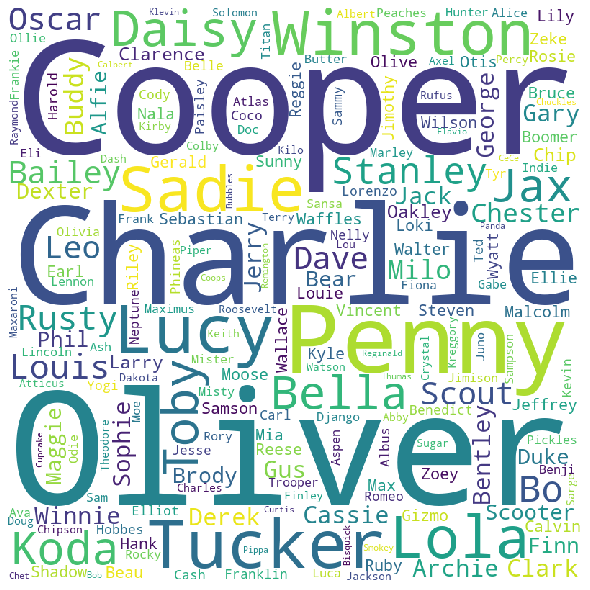

In [221]:
# Set up the wordcloud object
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [222]:
df_ta['name'].nunique()

911

## Conclusion

Thanks for taking the time to read my Jupyter Notebook, which ends here

[Ends]